# Esercizio8 - Pysam

Prendere in input un file in formato `BAM` che contiene allineamenti al cromosoma X (*reference*) e:

- controllare se sono presenti *paired-end* reads
- determinare le lunghezze degli introni supportati dagli allineamenti del file `BAM`, senza utilizzare il metodo `find_introns()`
- determinare la base della *reference* che ha la massima copertura in termini di reads allineati

### 1) Importare `pysam` e la classe `AlignmentFile`

In [1]:
import pysam

In [2]:
from pysam import AlignmentFile

### 2) Leggere il file `BAM` in input

In [3]:
pysam.index('./sample.bam')

''

In [4]:
bam_file = AlignmentFile('./sample.bam', 'rb')

In [5]:
bam_file

### 3) Controllare se sono presenti *paired-end* reads.

In [6]:
alignment_iter = bam_file.fetch()
alignment_list = list(alignment_iter)

any([alignment.is_paired for alignment in alignment_list])

False

### 4) Determinare le lunghezze degli introni supportati dagli allineamenti nel file `BAM`

a) Ricavare l'insieme delle lunghezze degli introni supportati dalle cigar strings che contengono un'operazione `N` (cioé un inserimento nella reference che corrisponde a un introne).

In [7]:
import re

In [8]:
set([int(re.search(r'(\d+)N', alignment.cigarstring).group(1)) for alignment in alignment_list if 'N' in alignment.cigarstring])

{57, 287, 309, 598, 980, 1514, 1999, 4116, 4226}

b) Verificare che si trova la stessa cosa utilizzando il metodo `find_introns()`

In [9]:
set([intron[1]-intron[0] for intron in bam_file.find_introns(bam_file.fetch())])

{57, 287, 309, 598, 980, 1514, 1999, 4116, 4226}

### 5) Trovare la base della reference che ha copertura massima

a) Determinare la lista delle colonne di *pileup*.

In [10]:
pileup_iter = bam_file.pileup()

In [11]:
pileup_columns = list(pileup_iter)

In [12]:
pileup_columns

 ...]

b) Estrarre le colonna di altezza massima (cioé coperta dal maggior numero di allineamenti).

In [13]:
max_height = max([pileup_col.nsegments for pileup_col in pileup_columns])

In [14]:
max_pileup_col = [pileup_col for pileup_col in pileup_columns if pileup_col.nsegments == max_height][0]

In [15]:
max_pileup_col.nsegments

1469

In [16]:
max_pileup_col.pos

286723

### 6) Disegnare un grafico che mostri posizioni di mappaggio e di refskip nel pileup

In [18]:
covs = []
skips = []

for pileupcolumn in bam_file.pileup(min_base_quality = 0):
    cov = pileupcolumn.nsegments
    skipcount = 0
    for pileupread in pileupcolumn.pileups:
        skipcount += pileupread.is_refskip
    covs.append(cov - skipcount)
    skips.append(skipcount)

<BarContainer object of 11777 artists>

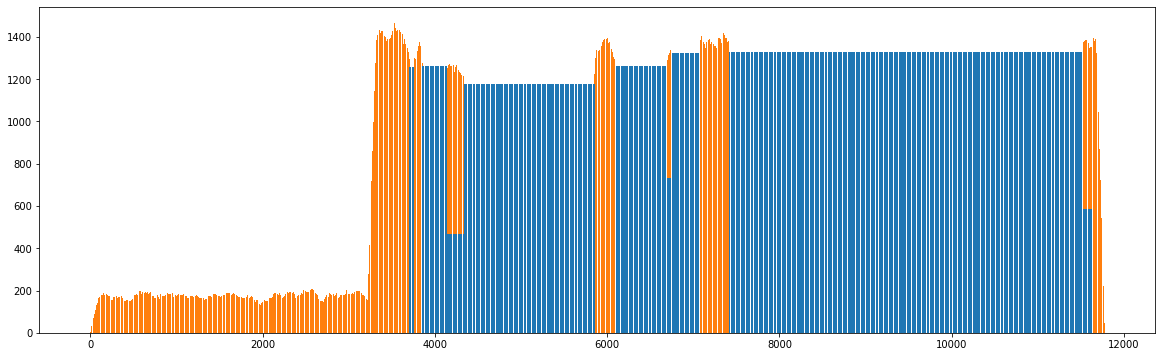

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,6))
plt.bar(range(len(skips)), skips)
plt.bar(range(len(covs)), covs, bottom=skips)